# This file allows you to reproduce the results from our paper

Load the data from AIS in a period 01-14 October 2025 and create parquet files.

In [ ]:
mkdir dataset
bash ./command_scripts/run_ais.sh

## Model training and testing

The model implementation for TPTrans, TPInform and TempTPI can be found in ``tptrans.py`` ``tpinform.py`` and ``temptpi.py`` respectively.

Each of these models were trained using the code found in `training.py`

### TPTrans Model Performance

Here you can run the test on the predefined model saved in `"checkpoints/t_1000_300_15_420_120_15_32_0.0001.pth"`

In [ ]:
import torch
import torch.nn as nn
from tptrans import *
from dataloader import load_parquet, preprocess_data, SlidingWindowDataset
from plotting import plot_testresult_sample
from torch.utils.data import DataLoader
from utils import deltas_to_coords

df = load_parquet("dataset", k=20)
df = preprocess_data(df)

dataset = SlidingWindowDataset(
    df,
    max_diff_per_sequence_minutes=15,
    window_size_minutes=420,
    pred_size_minutes=120,
    stride=15,
)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load("checkpoints/t_1000_300_15_420_120_15_32_0.0001.pth", map_location=torch.device(device))
model.eval()

criterion = nn.MSELoss()
test_loss = 0.0
data = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        # split the batch into individual samples along dim=0
        x_split = torch.split(x, 1, dim=0)
        y_split = torch.split(y, 1, dim=0)
        pred_split = torch.split(pred, 1, dim=0)
        # append each sample separately
        data.extend(zip(x_split, y_split, pred_split))
        loss = criterion(deltas_to_coords(x, pred), deltas_to_coords(x,y))
        test_loss += loss.item() * x.size(0)
test_loss /= len(test_loader.dataset)
#  (heavily influenced by training dataset, so its better to ignore the test loss here and only take from log)
print(f"Test Loss: {test_loss:.6f}", flush=True)

plot_testresult_sample(data)

/zhome/0a/d/219948/repos/DeepLearning/dataloader.py:167: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.set_index("Timestamp")
/zhome/0a/d/219948/repos/DeepLearning/dataloader.py:167: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.set_index("Timestamp")


393
Test Loss: 0.008221


: 

### TPInform Model Performance

In [ ]:
import torch
import torch.nn as nn
from dataloader import load_parquet, preprocess_data, SlidingWindowDataset
from plotting import plot_testresult_sample
from torch.utils.data import DataLoader
from utils import deltas_to_coords

df = load_parquet("dataset", k=10)
df = preprocess_data(df)

dataset = SlidingWindowDataset(
    df,
    max_diff_per_sequence_minutes=15,
    window_size_minutes=120,
    pred_size_minutes=30,
    stride=15,
)
print(len(dataset))

test_loader = DataLoader(dataset, batch_size=1, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load("checkpoints/tpinform_experiment_1500_300_20_420_120_15_64_0.0005.pth", map_location=torch.device(device), weights_only=False)
model.eval()

criterion = nn.MSELoss()
test_loss = 0.0
data = []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        data.append((x,y,pred))
        pred_coords = deltas_to_coords(x, pred)
        y_coords = deltas_to_coords(x, y)
                # Example: trim pred to match y along time dim
        min_len = min(pred_coords.size(1), y_coords.size(1))
        loss = criterion(pred_coords[:, :min_len], y_coords[:, :min_len])
        test_loss += loss.item() * x.size(0)
test_loss /= len(test_loader.dataset)
print(f"Test Loss: {test_loss:.6f}", flush=True)

plot_testresult_sample(data)

### TempTPI Model Performance

In [1]:
import torch
import torch.nn as nn
from tptrans import TPTrans
from temptpi import TempTPT, TemporalEncoding, TempTPI
from temptpi import TempTPT as TimeTPT, TemporalEncoding as BetterTemporalEncoding # some name remapping for older checkpoint files
from dataloader import load_parquet, preprocess_data, Dataset, SlidingWindowDatasetTemporal
from plotting import plot_testresult_sample_both
from torch.utils.data import DataLoader
from utils import deltas_to_coords

df = load_parquet("dataset", k=30)
df = preprocess_data(df)

dataset = SlidingWindowDatasetTemporal(
    df,
    max_diff_per_sequence_minutes=15,
    window_size_minutes=540,
    pred_size_minutes=180,
    stride=15,
)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load("checkpoints/large_data/temptpi_1500_300_15_540_180_15_32_0.0001.pth", map_location=torch.device(device))
model.eval()
model2 = torch.load("checkpoints/large_data/tprans_1500_300_15_540_180_15_32_0.0001.pth", map_location=torch.device(device))
model2.eval()

criterion = nn.MSELoss()
test_loss = 0.0
data = []
with torch.no_grad():
    for x, y in test_loader:
        x2 = x[:, :, :6].clone()
        x, y = x.to(device), y.to(device)
        x2 = x2.to(device)
        pred = model(x)
        pred2 = model2(x2)
        # split the batch into individual samples along dim=0
        x_split = torch.split(x, 1, dim=0)
        y_split = torch.split(y, 1, dim=0)
        pred_split = torch.split(pred, 1, dim=0)
        pred2_split = torch.split(pred2, 1, dim=0)
        # append each sample separately
        data.extend(zip(x_split, y_split, pred_split, pred2_split))
        loss = criterion(deltas_to_coords(x, pred), deltas_to_coords(x,y))
        test_loss += loss.item() * x.size(0)
test_loss /= len(test_loader.dataset)
#  (heavily influenced by training dataset, so its better to ignore the test loss here and only take from log)
print(f"Test Loss: {test_loss:.6f}", flush=True)

plot_testresult_sample_both(data)

/zhome/0a/d/219948/repos/DeepLearning/dataloader.py:167: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df.set_index("Timestamp")
/zhome/0a/d/219948/repos/DeepLearning/dataloader.py:167: FutureWarning: DataFrameGroupBy.resample operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.set_index("Timestamp")


UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.TempTPI was not an allowed global by default. Please use `torch.serialization.add_safe_globals([__main__.TempTPI])` or the `torch.serialization.safe_globals([__main__.TempTPI])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

# Performance Visualization on map

In [ ]:
import torch
import torch.nn as nn
from tptrans import TPTrans
from temptpi import TempTPT, TemporalEncoding, TempTPI
from temptpi import TempTPT as TimeTPT, TemporalEncoding as BetterTemporalEncoding # some name remapping for older checkpoint files
from dataloader import load_parquet, preprocess_data, Dataset, SlidingWindowDatasetTemporal
from plotting import plot_testresult_sample_both
from torch.utils.data import DataLoader
from utils import deltas_to_coords

df = load_parquet("dataset", k=30)
df = preprocess_data(df)

dataset = SlidingWindowDatasetTemporal(
    df,
    max_diff_per_sequence_minutes=15,
    window_size_minutes=540,
    pred_size_minutes=180,
    stride=15,
)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torch.load("checkpoints/large_data/temptpi_1500_300_15_540_180_15_32_0.0001.pth", map_location=torch.device(device))
model.eval()
model2 = torch.load("checkpoints/large_data/tprans_1500_300_15_540_180_15_32_0.0001.pth", map_location=torch.device(device))
model2.eval()

criterion = nn.MSELoss()
test_loss = 0.0
data = []
with torch.no_grad():
    for x, y in test_loader:
        x2 = x[:, :, :6].clone()
        x, y = x.to(device), y.to(device)
        x2 = x2.to(device)
        pred = model(x)
        pred2 = model2(x2)
        # split the batch into individual samples along dim=0
        x_split = torch.split(x, 1, dim=0)
        y_split = torch.split(y, 1, dim=0)
        pred_split = torch.split(pred, 1, dim=0)
        pred2_split = torch.split(pred2, 1, dim=0)
        # append each sample separately
        data.extend(zip(x_split, y_split, pred_split, pred2_split))
        loss = criterion(deltas_to_coords(x, pred), deltas_to_coords(x,y))
        test_loss += loss.item() * x.size(0)
test_loss /= len(test_loader.dataset)
#  (heavily influenced by training dataset, so its better to ignore the test loss here and only take from log)
print(f"Test Loss: {test_loss:.6f}", flush=True)

plot_testresult_sample_both(data)

# Ablation Studies

A systematic ablation study was designed to investigate the model’s sensitivity to the data sampling parameters and its impact on the performance quality of each model. The experiment was split into 2 testing conditions:
1. Input-output window timeframe
2. Input larger/smaller dataset

Furthermore, a testing on a larger data set was performed to prevent underfitting.

All three scenarios we run `ablation_studies/ablation_test.sh` script that output the loss function for the model.

## Ablation study for changing window size

This study tested the different configurations of the past and prediction window times. The following configurations have been used for testing:
- window_size_minutes = [240, 360, 480]  # 4h, 6h, 8h
- pred_size_minutes = [60, 120, 180, 240, 300]  # 1h, 2h, 3h, 4h, 5h
- stride = [30]
- k = [1000]  # MMSIs

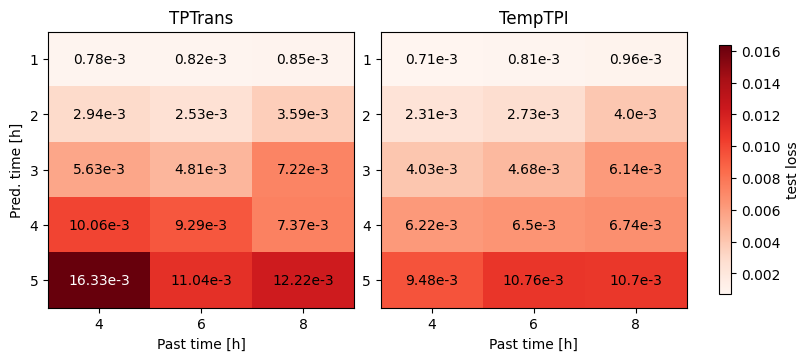

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colormaps



# ------------------------------------------------------------
# Configuration
# ------------------------------------------------------------
cols = ["240", "360", "480"]                       # window size columns
rows = ["60", "120", "180", "240", "300"]          # prediction horizons
#titles = ["TPTrans", "TPInform", "TempTPI"]
titles = ["TPTrans", "TempTPI"]


csv_TPT = "ablation_studies/results_TPTrans_b1.csv"
#csv_TPI = "results_TPInform_b1.csv"
csv_TTPI = "ablation_studies/results_TempTPI_b1.csv"

#files = [csv_TPT, csv_TPI, csv_TTPI]
files = [csv_TPT, csv_TTPI]
datasets = []

# ------------------------------------------------------------
# Helper: convert raw CSV into matrix for each heatmap
# ------------------------------------------------------------
def make_matrix(df):
    # df entries contain window_size_minutes and pred_size_minutes
    # rows: pred_size_minutes
    # cols: window_size_minutes
    mat = np.full((len(rows), len(cols)), np.nan)

    for i, r in enumerate(rows):
        for j, c in enumerate(cols):
            val = df.loc[
                (df["pred_size_minutes"] == int(r)) &
                (df["window_size_minutes"]-df["pred_size_minutes"] == int(c)),
                "test_loss"
            ]
            if not val.empty:
                mat[i, j] = val.iloc[0]
    return mat

# ------------------------------------------------------------
# Load CSVs and build matrices
# ------------------------------------------------------------
for f in files:
    df = pd.read_csv(f)
    datasets.append(make_matrix(df))

# global color limits shared across heatmaps
vmin = np.nanmin([np.nanmin(m) for m in datasets])
vmax = np.nanmax([np.nanmax(m) for m in datasets])

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5), constrained_layout=True)

cmap = colormaps["Reds"]
for e, (ax, mat, title) in enumerate(zip(axes, datasets, titles)):
    im = ax.imshow(mat, vmin=vmin, vmax=vmax, aspect="auto", cmap=cmap)
    ax.set_title(title)
    ax.set_xticks(range(len(cols)))
    ax.set_yticks(range(len(rows)))
    ax.set_xticklabels([str(int(x)//60) for x in cols])
    ax.set_yticklabels([str(int(x)//60) for x in rows])
    ax.set_xlabel("Past time [h]")
    if e==0: 
        ax.set_ylabel("Pred. time [h]")
    # write values into cells
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if not np.isnan(mat[i, j]):
                ax.text(j, i, f"{round(mat[i,j]*1000, 2)}e-3",
                        ha="center", va="center", color="black" if mat[i,j]<0.0125 else "white")

# single shared colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.9)
cbar.set_label("test loss")

plt.show()

## Ablation Study for changing MMSI input size

The study tested how will the model perform under the different MMSI dataset size and smaller stride. For this study we used the following parameters configurations:
- window_size_minutes = [480]  # 8h
- pred_size_minutes = [300]  # 5h
- stride = [15, 30]  # 15min, 30min
- k = [100, 500, 1000]  # MMSIs 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colormaps

# ------------------------------------------------------------
# Inputs: paths to the three CSV files
# ------------------------------------------------------------
csv_TPT = "ablation_studies/results_TPTrans_b2.csv"
#csv_TPI = "results_TPInform_b2.csv"
csv_TTPI = "ablation_studies/results_TempTPI_b2.csv"

# ------------------------------------------------------------
# Configuration
# ------------------------------------------------------------
cols = ["15", "30"]                       # window size columns
rows = ["100", "500", "1000"]          # prediction horizons
#titles = ["TPTrans", "TPInform", "TempTPI"]
titles = ["TPTrans", "TempTPI"]

#files = [csv_TPT, csv_TPI, csv_TTPI]
files = [csv_TPT, csv_TTPI]
datasets = []

# ------------------------------------------------------------
# Helper: convert raw CSV into matrix for each heatmap
# ------------------------------------------------------------
def make_matrix(df):
    # df entries contain window_size_minutes and pred_size_minutes
    # rows: pred_size_minutes
    # cols: window_size_minutes
    mat = np.full((len(rows), len(cols)), np.nan)

    for i, r in enumerate(rows):
        for j, c in enumerate(cols):
            val = df.loc[
                (df["k"] == int(r)) &
                (df["stride"] == int(c)),
                "test_loss"
            ]
            if not val.empty:
                mat[i, j] = val.iloc[0]
    return mat

# ------------------------------------------------------------
# Load CSVs and build matrices
# ------------------------------------------------------------
for f in files:
    df = pd.read_csv(f)
    datasets.append(make_matrix(df))

# global color limits shared across heatmaps
vmin = np.nanmin([np.nanmin(m) for m in datasets])
vmax = np.nanmax([np.nanmax(m) for m in datasets])

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(7.5, 3), constrained_layout=True)

cmap = colormaps["Reds"]
for e, (ax, mat, title) in enumerate(zip(axes, datasets, titles)):
    im = ax.imshow(mat, vmin=vmin, vmax=vmax, aspect="auto", cmap=cmap)
    ax.set_title(title)
    ax.set_xlabel("Dataset Stride (mins)")
    ax.set_xticks(range(len(cols)))
    ax.set_yticks(range(len(rows)))
    ax.set_xticklabels(cols)
    ax.set_yticklabels(rows)
    if e==0:
        ax.set_ylabel("Sampled MMSIs")
    # write values into cells
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if not np.isnan(mat[i, j]):
                ax.text(j, i, f"{round(mat[i,j]*100, 2)}e-2",
                        ha="center", va="center", color="black" if mat[i,j]<0.1 else "white")

# single shared colorbar
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.9)
cbar.set_label("test loss")

plt.show()

## Ablation Study on large dataset

For the comparison the ablation study was executed on the larger dataset with an increasing sample number for increasing prediction length to prevent underfitting. For this we used the following configurations: 
- 300 epochs
- 6h past time
- 15min stride
- For 1+2h prediction, k=1000
- For 3h pred., k=1500
- For 4+5h pred., k=2000

The performace of all models in this test can be seen below


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np
from scipy.optimize import curve_fit

# Read the CSV file
df = pd.read_csv("ablation_studies/results_large_data.csv", sep=",", engine="python")

# Clean column names and remove trailing semicolons if present
df["test_loss"] = df["test_loss"].astype(float)
df["model"] = df["model"].astype(str)

def f_quad(x, a, b, c):  return a*x**2 + b*x + c

# Plot
plt.figure(figsize=(8, 5))
colors = ["b","g","r"]
for col, (model, group) in zip(colors, df.groupby("model")):
    # Fit curve
    x = np.arange(1, len(group) + 1)
    y = group["test_loss"].values
    popt, _ = curve_fit(f_quad, x, y, maxfev=10000)
    # Smooth curve for visualization
    x_smooth = np.linspace(1, len(group), 200)
    y_smooth = f_quad(x_smooth, *popt)

    # Plot real data
    plt.plot(x, y, alpha=0.3, label=f"{model}", c=col)
    plt.plot(x, y, "x", c=col)
    # Plot fitted curve
    plt.plot(x_smooth, y_smooth, alpha=1, c=col)

plt.xlabel("Prediction time (hours)")
plt.ylabel("Test loss (MSE)")
plt.title("Model Test Loss Comparison")
plt.legend()
plt.xticks(range(1,6))
plt.yticks([x*5/10000 for x in range(1,7)])
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
plt.grid(True, which="major")
plt.tight_layout()
plt.show()

In [ ]:
import re
from pathlib import Path
import matplotlib.pyplot as plt

# Patterns to match your log format
EPOCH_RE = re.compile(
    r"Epoch\s+(\d+)/\d+\s*\|\s*Train Loss:\s*([0-9.eE+-]+)\s*\|\s*Val Loss:\s*([0-9.eE+-]+)"
)
TEST_RE = re.compile(r"Test Loss:\s*([0-9.eE+-]+)")

def parse_log(path):
    """
    Parse a training log file with lines like:
    Epoch 1/400 | Train Loss: ... | Val Loss: ...
    Test Loss: ...
    """
    path = Path(path)
    epochs = []
    train_losses = []
    val_losses = []
    test_loss = None

    with path.open("r") as f:
        for line in f:
            line = line.strip()

            # Epoch line
            m = EPOCH_RE.search(line)
            if m:
                epoch = int(m.group(1))
                train = float(m.group(2))
                val = float(m.group(3))
                epochs.append(epoch)
                train_losses.append(train)
                val_losses.append(val)
                continue

            # Test loss line
            t = TEST_RE.search(line)
            if t:
                test_loss = float(t.group(1))

    return {
        "epochs": epochs,
        "train": train_losses,
        "val": val_losses,
        "test_loss": test_loss,
        "name": "TempTPI" if "temptpi" in path.stem else "TPTrans",
    }



def plot_runs(log_paths):
    runs = [parse_log(p) for p in log_paths]

    runs = [r for r in runs if r["epochs"]]
    if not runs:
        print("No valid runs parsed.")
        return

    plt.figure(figsize=(10, 6))
    ax = plt.gca()

    cols = ["g", "r"]
    for i,run in enumerate(runs):
        name = run["name"]
        epochs = run["epochs"]
        train = run["train"]
        val = run["val"]

        # Train (solid)
        ax.plot(
            epochs, train,
            label=f"{name} – Train",
            c=cols[i]
        )

        # Validation (dashed)
        ax.plot(
            epochs, val,
            linestyle="--",
            label=f"{name} – Val",
            alpha=0.5,
            c=cols[i]
        )
        ax.fill_between(
            epochs,
            train,
            val,
            color=cols[i],
            alpha=0.25,       # light transparency keeps plot readable
        )

    ax.set_title("Train & Validation Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss (MSE)")
    ax.set_yscale("log")
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.show()


plot_runs([
    "../import_performance_log_files/results_with_large_data/tpt_5h.log",
    "../import_performance_log_files/results_with_large_data/temptpi_5h.log",
])